In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('DFT_ESP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_name          68 non-null     object 
 1   Cate_HOMO          68 non-null     float64
 2   Cate_LUMO          68 non-null     float64
 3   Cate_ESP_O1        68 non-null     float64
 4   Cate_ESP_H1        68 non-null     float64
 5   Cate_ESP_O2        68 non-null     float64
 6   Cate_ESP_H2        68 non-null     float64
 7   Cate_BL_ArO1       68 non-null     float64
 8   Cate_BL_O1H1       68 non-null     float64
 9   Cate_BL_ArO2       68 non-null     float64
 10  Cate_BL_O2H2       68 non-null     float64
 11  Cate_total_dipole  68 non-null     float64
 12  P_name             68 non-null     object 
 13  P_HOMO             68 non-null     float64
 14  P_LUMO             68 non-null     float64
 15  P_ESP_P            68 non-null     float64
 16  P_ESP_=O           68 non-nu

In [3]:
#Building descriptors
X = df.drop(columns=['Yield', 'Cate_name', 'P_name' ])
print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_HOMO  Cate_LUMO  Cate_ESP_O1  Cate_ESP_H1  Cate_ESP_O2  Cate_ESP_H2  \
0      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
1      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
2      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
3      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
4      -5.51       0.22    -0.542028     0.433177    -0.582447     0.440296   

   Cate_BL_ArO1  Cate_BL_O1H1  Cate_BL_ArO2  Cate_BL_O2H2  Cate_total_dipole  \
0         1.363         0.969         1.378         0.965           2.484773   
1         1.363         0.969         1.378         0.965           2.484773   
2         1.363         0.969         1.378         0.965           2.484773   
3         1.363         0.969         1.378         0.965           2.484773   
4         1.364         0.969         1.379         0.965           2.303134   

   P_HOMO  P_LUMO   P_ESP_

In [4]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []

#MLP
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_y_train = y_train/10
    
    param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
               'learning_rate_init':[0.003,0.03]}
    
    reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
    reg_mlp.fit(a_X_train,a_y_train['Yield'])
    reg_best = reg_mlp.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)*10
    y_pred2 = reg_best.predict(a_X_test)*10
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
    #strage data of accuracy 
    parametors = reg_mlp.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_mlp.best_score_)
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_mlp.best_params_)
    print("Best Model Score:",reg_mlp.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
Best Model Parameter: {'alpha': 5, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.7393134658698644
R2_test: 0.7295980046982895
----------------------
seed: 1
Best Model Parameter: {'alpha': 3, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.7429452175978373
R2_test: 0.712525255355382
----------------------
seed: 2
Best Model Parameter: {'alpha': 4, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.764849906371858
R2_test: 0.7960251257498876
----------------------
seed: 3
Best Model Parameter: {'alpha': 3, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.7395820881858925
R2_test: 0.8327668394657204
----------------------
seed: 4
Best Model Parameter: {'alpha': 5, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.75509939148

In [5]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['RMSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])

data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, 
                      data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd],
                     axis=1, join='inner')

data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/DFT/MLP_score.csv')

      r2_train  RMSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.948277   38.133715   3.667226  0.729598  353.672320  13.568581   
1     0.974012   23.501429   3.168231  0.712525  278.519352  12.688941   
2     0.944256   51.568391   4.472210  0.796025  197.256192   9.116148   
3     0.964797   32.834124   3.311330  0.832767  160.501362   8.208721   
4     0.927171   62.785794   4.815164  0.784404  229.248593   9.856946   
5     0.894188   85.679879   5.198231  0.782383  264.667039  11.081821   
6     0.910398   73.534053   4.699529  0.772722  273.519714  11.371676   
7     0.934831   62.333676   5.280988  0.793062  187.590826   8.989892   
8     0.925543   65.530540   4.753354  0.835791  162.276766   9.222072   
9     0.942902   57.865209   4.928869  0.922860   54.357521   6.048540   
mean  0.936638   55.376681   4.429513  0.796214  216.160969  10.015334   

      cv_score  
0     0.739313  
1     0.742945  
2     0.764850  
3     0.739582  
4     0.755099  
5     0.7

In [6]:
seed=3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#autoscaling
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_y_train = y_train/10

param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
               'learning_rate_init':[0.003,0.03]}
    
reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
reg_mlp.fit(a_X_train,a_y_train['Yield'])
reg_best = reg_mlp.best_estimator_
y_pred1 = reg_best.predict(a_X_train)*10
y_pred2 = reg_best.predict(a_X_test)*10
            
#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
print('R2_train:', r2_train)
print('R2_test:', r2_test)

R2_train: 0.9647970978798107
R2_test: 0.8327668394657204


  0%|          | 0/47 [00:00<?, ?it/s]

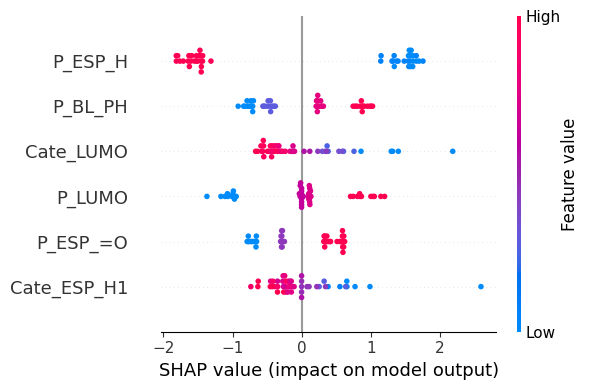

In [7]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(reg_best.predict, a_X_train)
shap_values = explainer.shap_values(a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=6, plot_size=(6,4))